In [2]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import curve_fit

In [3]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
        )

In [4]:
def read_sql(query):
    return pd.read_sql(query, con=ms_sql_con(), parse_dates=None)

In [5]:
def phrases_per_hour(date_from, date_to, phrase):
    query = "select month(record_date) as m,  day(record_date) as d, DATEPART(HOUR, record_date) as h, count(id) as c" 
    query += " from transcribations where "
    query += " record_date > '"+date_from+"' and "
    query += " record_date < '"+date_to+"' and "
    query += " text like '%"+phrase+"%' "
    query += " group by month(record_date), day(record_date), DATEPART(HOUR, record_date)"
    query += " order by month(record_date), day(record_date), DATEPART(HOUR, record_date);"
    df = read_sql(query)
    
    df.drop(['m', 'd'], axis = 1, inplace = True)
    df = df.groupby(df.h).median()
    df.reset_index(level=0, inplace=True)
    
    plt.bar(df.h, df.c)
    plt.show()

In [6]:
def silence_timing(date_from, date_to):

    def convert_false(val):
        return not val
    
    query = "select"
    query += " sum(end_time - start) as time,"
    query += " DATEPART(HOUR, record_date) as h,"
    query += " linkedid,"
    query += " side,"
    query += " duration"
    query += " from transcribations"
    query += " where"
    query += " record_date > '"+date_from+"' and "
    query += " record_date < '"+date_to+"' and"
    query += " duration > 0 "
    query += " group by record_date, linkedid, side, duration"
    query += " order by linkedid, side;"
    df = read_sql(query)
    df['a'] = df.time*df.side
    df.side = df.side.apply(convert_false)
    df['b'] = df.time*df.side
    df.drop(['time', 'side'], axis = 1, inplace = True)
    df = df.groupby(['h', 'linkedid', 'duration']).sum()
    df.reset_index(level=0, inplace=True)
    df.reset_index(level=0, inplace=True)
    df.reset_index(level=0, inplace=True)
    df.drop(['linkedid'], axis = 1, inplace = True)
    df.reset_index(level=0, inplace=True)
    df['part_a'] = df.a/df.duration
    df['part_b'] = df.b/df.duration
    df['part_silence'] = 1 - df.part_a - df.part_b
    df.drop(['duration', 'a', 'b'], axis = 1, inplace = True)
    df = df.groupby(['h']).mean()
    df.reset_index(level=0, inplace=True)
    df.drop(['index'], axis = 1, inplace = True)
    df.sort_values(['h'], inplace = True)
    df.plot(x = 'h', y = ['part_a', 'part_b', 'part_silence'], style = '.')    

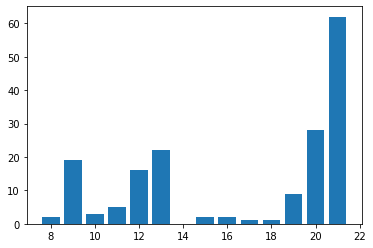

In [7]:
phrases_per_hour('2021-03-04 00:00:00', '2021-03-05 00:00:00', 'операторы заняты')

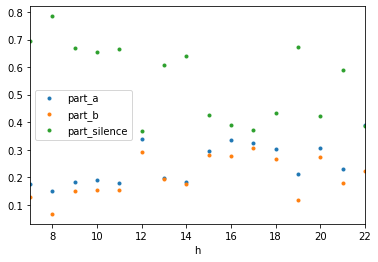

In [8]:
silence_timing('2021-03-01 00:00:00', '2021-03-02 00:00:00')

In [9]:
### developing

In [10]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
df = read_sql(query)
df

,column_name
0,transcribation_date
1,date_y
2,date_m
3,date_d
4,side
5,text
6,start
7,audio_file_name
8,conf
9,end_time
